### 09_GAN_mnist

In [1]:
import os,sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,models,optimizers,Sequential,metrics,losses,utils
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.preprocessing import sequence

print(sys.version)
print(tf.test.is_gpu_available())
print(tf.__version__)

3.6.12 |Anaconda, Inc.| (default, Sep  9 2020, 00:29:25) [MSC v.1916 64 bit (AMD64)]
False
2.0.0


In [3]:
class_names = ["零","壹","貳","參","肆","伍","陸","柒","捌","玖"]

batch_size = 256
inputs_shape = [-1, 28, 28, 1]

def data_normalize(train, test, scale=1):
    (x_train,y_train) = train
    (x_test,y_test) = test
    train_nums = x_train.shape[0] // scale
    test_nums = x_test.shape[0] // scale
    x_train, y_train = x_train[:train_nums], y_train[:train_nums]
    x_test, y_test = x_test[:train_nums], y_test[:train_nums]
    x_train = x_train.astype(np.float32) / 255.
    x_test = x_test.astype(np.float32) / 255.
    
    x_train = tf.expand_dims(x_train, axis=-1)
    x_test = tf.expand_dims(x_test, axis=-1)
    #x_train = tf.reshape(x_train, shape=(-1,28*28))
    #x_test = tf.reshape(x_test, shape=(-1,28*28))
    #y_train = utils.to_categorical(y_train)#.astype(np.int32)
    #y_test = utils.to_categorical(y_test)
    print(x_train.shape,y_train.shape)
    print(x_test.shape,y_test.shape)
    
    return (x_train,y_train),(x_test,y_test)

(x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)
(x_train,y_train),(x_test,y_test) = data_normalize((x_train,y_train),(x_test,y_test),scale=10)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(6000, 28, 28, 1) (6000,)
(6000, 28, 28, 1) (6000,)


In [12]:
class Generator(models.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_f = 512
        self.n_k = 4
        # input z vector is [None, 100]
        self.dense1 = layers.Dense(3 * 3 * self.n_f)
        self.conv2 = layers.Conv2DTranspose(self.n_f // 2, 3, 2, 'valid')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2DTranspose(self.n_f // 4, self.n_k, 2, 'same')
        self.bn3 = layers.BatchNormalization()
        self.conv4 = layers.Conv2DTranspose(1, self.n_k, 2, 'same')
        
    def call(self, inputs, training=None):
        # [b, 100] => [b, 3, 3, 512]
        x = tf.nn.leaky_relu(tf.reshape(self.dense1(inputs), shape=[-1, 3, 3, self.n_f]))
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training))
        x = tf.tanh(self.conv4(x))
        return x
    
class Discriminator(models.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_f = 64
        self.n_k = 4
        # input image is [-1, 28, 28, 1]
        self.conv1 = layers.Conv2D(self.n_f, self.n_k, 2, 'same')
        self.conv2 = layers.Conv2D(self.n_f * 2, self.n_k, 2, 'same')
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(self.n_f * 4, self.n_k, 2, 'same')
        self.bn3 = layers.BatchNormalization()
        self.flatten4 = layers.Flatten()
        self.dense4 = layers.Dense(1)        

    def call(self, inputs, training=None):
        x = tf.nn.leaky_relu(self.conv1(inputs))
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training))
        x = self.dense4(self.flatten4(x))
        return x
    

g_model = Generator()
d_model = Discriminator()

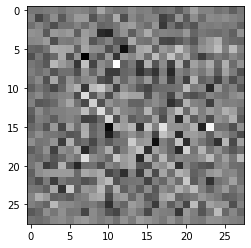

In [13]:
noise = tf.random.normal([1, 100])
generated_image = g_model(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [14]:
decision = d_model(generated_image)
print (decision)

tf.Tensor([[0.0002087]], shape=(1, 1), dtype=float32)


In [15]:
z_dim = 50
epochs = 10
batch_size = 128
learning_rate = 0.001
is_training = True

generator = Generator()
generator.build(input_shape=(batch_size, z_dim))
generator.summary()
discriminator = Discriminator()
discriminator.build(input_shape=(batch_size, 28, 28, 1))
discriminator.summary()

# prepare optimizer
d_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
g_optimizer = optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)

Model: "generator_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              multiple                  235008    
_________________________________________________________________
conv2d_transpose_12 (Conv2DT multiple                  1179904   
_________________________________________________________________
batch_normalization_16 (Batc multiple                  1024      
_________________________________________________________________
conv2d_transpose_13 (Conv2DT multiple                  524416    
_________________________________________________________________
batch_normalization_17 (Batc multiple                  512       
_________________________________________________________________
conv2d_transpose_14 (Conv2DT multiple                  2049      
Total params: 1,942,913
Trainable params: 1,942,145
Non-trainable params: 768
___________________________________________

In [19]:
def loss_real(logits):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                                  labels=tf.ones_like(logits)))

def loss_fake(logits):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                                  labels=tf.zeros_like(logits)))

def dis_loss(generator, discriminator, input_noise, real_image, is_trainig):
    fake_image = generator(input_noise, is_trainig)
    d_real_logits = discriminator(real_image, is_trainig)
    d_fake_logits = discriminator(fake_image, is_trainig)

    d_loss_real = loss_real(d_real_logits)
    d_loss_fake = loss_fake(d_fake_logits)
    loss = d_loss_real + d_loss_fake
    return loss

def gen_loss(generator, discriminator, input_noise, is_trainig):
    fake_image = generator(input_noise, is_trainig)
    fake_loss = discriminator(fake_image, is_trainig)
    loss = loss_real(fake_loss)
    return loss

In [20]:
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(batch_size*4).batch(batch_size).repeat()
train_data_iter = iter(train_data)

epochs = 3
for epoch in range(epochs):

    batch_x = next(train_data_iter)
    batch_x = tf.reshape(batch_x, shape=inputs_shape)
    batch_x = batch_x * 2.0 - 1.0
    batch_z = tf.random.normal(shape=[batch_size, z_dim])

    with tf.GradientTape() as tape:
        d_loss = dis_loss(generator, discriminator, batch_z, batch_x, is_training)
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    with tf.GradientTape() as tape:
        g_loss = gen_loss(generator, discriminator, batch_z, is_training)
    grads = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    if (epoch+1) % 1 == 0:
        print(epoch, 'd loss:', float(d_loss), 'g loss:', float(g_loss))

0 d loss: 1.4964191913604736 g loss: 7.191082954406738
1 d loss: 10.478962898254395 g loss: 9.239917755126953
2 d loss: 1.0888245105743408 g loss: 15.87679386138916


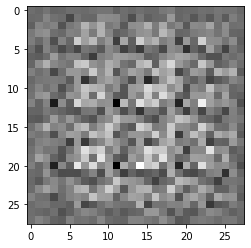

In [21]:
noise = tf.random.normal([1, 50])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')